# aws-smsl-predict-airquality-via-weather
A Jupyter Notebook that connects to Amazon Sustainability Data Initiative (ASDI) datasets from NOAA and OpenAQ to build a Machine Learning (ML) model to predict air quality via weather.

## PROBLEM: 1 out of 8 deaths in the world is due to poor air quality*
This notebook explores correlations between weather and air quality since we know factors like temperatures, wind speeds, etc, affect certain air quality parameters. Predicting air quality based on weather can get into highly sophisticated ML techniques, but this demo shows how merging NOAA GSOD weather data with OpenAQ air quality data to build an ML model using AutoGluon (AutoML from AWS) can result in prediction accuracy of ~75-90% using Binary Classification models for various high-pollution areas and air quality parameters (mostly tested for 2.5 micron Particulate Matter and some Ground Level Ozone).\
*Source: [OpenAQ.org](https://OpenAQ.org)

### Top 5 US Locations with Worst Air Quality
Source: https://www.lung.org/research/sota/city-rankings/most-polluted-cities
- By Particulate Pollution
  1. Bakersfield, CA
  2. Fresno-Madera-Hanford, CA
  3. Visalia, CA
  4. San Jose-San Francisco-Oakland, CA
  5. Los Angeles-Long Beach, CA
- By Ground Level Ozone
  1. Los Angeles-Long Beach, CA
  2. Bakersfield, CA
  3. Visalia, CA
  4. Fresno-Madera-Hanford, CA
  5. Phoenix-Mesa, AZ

## INSTRUCTIONS
- Configure your environment using the environment.yml file or by running the *pip install* commands below.
- CELL #3: Review the Variables and Classes defined in this cell to see defaults and how ASDI access occurs.
- CELL #4: Review the defined AQParams and Scenarios in this cell. You can edit these and/or use your own.
- CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process.
- Step through the remaining cells in the Notebook to access data, merge data, and build a Binary Classification Autogluon model.

### NOTES
- NOAA and OpenAQ input data is saved locally as CSV files and re-used, when possible. This can cause an issue if you're re-running a scenario with differing relevant columns. So if you change columns and want to re-run a scenario, you should delete the associated local files to cause the Notebook to re-fetch and re-save data.

In [1]:
# Set up your environment according to the environment.yml file or run the following...
# Comment these out, once installed or otherwise not needed.
%pip install boto3        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install pandas       -r pip_requirements.txt | grep -v 'already satisfied'
%pip install numpy        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install requests     -r pip_requirements.txt | grep -v 'already satisfied'
%pip install ipywidgets   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install scikit-learn -r pip_requirements.txt | grep -v 'already satisfied'
%pip install autogluon    -r pip_requirements.txt | grep -v 'already satisfied'
%pip install matplotlib   -r pip_requirements.txt | grep -v 'already satisfied'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements for packages used...
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import requests
import json
import ipywidgets as widgets

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from datetime import datetime
from types import SimpleNamespace

In [3]:
# CELL #3: Review the Variables and Classes defined in this cell to see defaults and how ASDI access occurs...
# Note: OpenAQ data mostly begins sometime in 2016, so using that as yearStart value.

# class AQParam => Used to define attributes for the (6) main OpenAQ parameters.
class AQParam:
    def __init__(self, id, name, unit, unhealthyThresholdDefault, desc):
        self.id                        = id
        self.name                      = name
        self.unit                      = unit
        self.unhealthyThresholdDefault = unhealthyThresholdDefault
        self.desc                      = desc
    
    def isValid(self):
        if(self is not None and self.id > 0 and self.unhealthyThresholdDefault > 0.0 and 
           len(self.name) > 0 and len(self.unit) > 0 and len(self.desc) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQScenario => Defines an ML scenario including a Location that includes a NOAA Weather Station ID and the target OpenAQ Param.
class AQScenario:
    def __init__(self, location=None, noaaStationID=None, aqParamTarget=None, unhealthyThreshold=None, 
                 yearStart=2016, yearEnd=2022, aqRadiusMiles=10, featureColumnsToDrop=None):
        self.location           = location
        self.name               = location + "_" + aqParamTarget.name
        self.noaaStationID      = noaaStationID
        self.noaaStationLat     = 0.0
        self.noaaStationLng     = 0.0
        self.openAqLocIDs       = []
        
        self.aqParamTarget      = aqParamTarget
        
        if unhealthyThreshold and unhealthyThreshold > 0.0:
            self.unhealthyThreshold = unhealthyThreshold
        else:
            self.unhealthyThreshold = self.aqParamTarget.unhealthyThresholdDefault
        
        self.yearStart          = yearStart
        self.yearEnd            = yearEnd
        self.aqRadiusMiles      = aqRadiusMiles
        self.aqRadiusMeters     = aqRadiusMiles * 1610 # Rough integer approximation is fine here.
            
    def getSummary(self):
        return f"{self.name} => {self.aqParamTarget.desc} ({self.aqParamTarget.name}) with UnhealthyThreshold > {self.unhealthyThreshold} {self.aqParamTarget.unit}"
            
    def printSummary(self):
        print(f"Scenario: {self.getSummary()}")
    
    def getModelPath(self):
        return f"AutogluonModels/aq_{self.name}_{self.yearStart}-{self.yearEnd}/"
    
    def updateNoaaStationLatLng(self, noaagsod_df_row):
        if(noaagsod_df_row is not None and noaagsod_df_row['LATITUDE'] and noaagsod_df_row['LONGITUDE']):
            self.noaaStationLat = noaagsod_df_row['LATITUDE']
            self.noaaStationLng = noaagsod_df_row['LONGITUDE']
            print(f"NOAA Station Lat,Lng Updated for Scenario: {self.name} => {self.noaaStationLat},{self.noaaStationLng}")
        else:
            print("NOAA Station Lat,Lng COULD NOT BE UPDATED.")
    
    def isValid(self):
        if(self is not None and self.aqParamTarget is not None and
           self.yearStart > 0 and self.yearEnd > 0 and self.yearEnd >= self.yearStart and 
           self.aqRadiusMiles > 0 and self.aqRadiusMeters > 0 and self.unhealthyThreshold > 0.0 and 
           len(self.name) > 0 and len(self.noaaStationID) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQbyWeatherApp => Main app class with settings, AQParams, AQScenarios, and data access methods...
class AQbyWeatherApp:
    def __init__(self, mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy', mlTimeLimitSecs=None):
        self.mlTargetLabel   = mlTargetLabel
        self.mlEvalMetric    = mlEvalMetric
        self.mlTimeLimitSecs = mlTimeLimitSecs
        self.mlIgnoreColumns = ['DATE','NAME','LATITUDE','LONGITUDE','day','unit','average','parameter']
        
        self.defaultColumnsNOAA   = ['DATE','NAME','LATITUDE','LONGITUDE',
                                     'DEWP','WDSP','MAX','MIN','PRCP','MONTH'] # Default relevant NOAA columns
        self.defaultColumnsOpenAQ = ['day','parameter','unit','average']       # Default relevant OpenAQ columns
        
        self.aqParams    = {} # A list to save AQParam objects
        self.aqScenarios = {} # A list to save AQScenario objects
        
        self.selectedScenario = None
    
    def addAQParam(self, aqParam):
        if aqParam and aqParam.isValid():
            self.aqParams[aqParam.name] = aqParam
            return True
        else:
            return False
    
    def addAQScenario(self, aqScenario):
        if aqScenario and aqScenario.isValid():
            self.aqScenarios[aqScenario.name] = aqScenario
            if(self.selectedScenario is None):
                self.selectedScenario = self.aqScenarios[next(iter(self.aqScenarios))] # Default selectedScenario to 1st item.
            return True
        else:
            return False
    
    def getFilenameNOAA(self):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"dataNOAA_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{self.selectedScenario.noaaStationID}.csv"
        else:
            return ""
    
    def getFilenameOpenAQ(self):
        if self and self.selectedScenario and self.selectedScenario.isValid() and len(self.selectedScenario.openAqLocIDs) > 0:
            idString = ""
            for i in range(0, len(self.selectedScenario.openAqLocIDs)):
                idString = idString + str(self.selectedScenario.openAqLocIDs[i]) + "-"
            idString = idString[:-1]
            return f"dataOpenAQ_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{idString}.csv"
        else:
            return ""
    
    def getFilenameOther(self, prefix):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"{prefix}_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}.csv"
    
    def getNoaaDataFrame(self):
        # ASDI Dataset Name: NOAA GSOD
        # ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
        # NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
        # NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
        # Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        noaagsod_df = pd.DataFrame()
        filenameNOAA = self.getFilenameNOAA()

        if os.path.exists(filenameNOAA):
            # Use local data file already accessed + prepared...
            print('Loading NOAA GSOD data from local file: ', filenameNOAA)
            noaagsod_df = pd.read_csv(filenameNOAA)
        else:
            # Access + prepare data and save to a local data file...
            noaagsod_bucket = 'noaa-gsod-pds'
            print(f'Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})...')
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

            for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                key = f'{year}/{self.selectedScenario.noaaStationID}.csv'                                    # Compute the key to get
                csv_obj = s3.get_object(Bucket=noaagsod_bucket, Key=key)                                     # Get the S3 object
                csv_string = csv_obj['Body'].read().decode('utf-8')                                          # Read object contents to a string
                noaagsod_df = pd.concat([noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True) # Use the string to build the DataFrame

            # Perform some Feature Engineering to append potentially useful columns to our dataset... (TODO: Add more to optimize...)
            # It may be true that Month affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
            noaagsod_df['MONTH'] = pd.to_datetime(noaagsod_df['DATE']).dt.month

            # Trim down to the desired key columns... (do this last in case engineered columns are to be removed)
            noaagsod_df = noaagsod_df[self.defaultColumnsNOAA]
            
        return noaagsod_df
        
    def getOpenAqDataFrame(self):
        # ASDI Dataset Name: OpenAQ
        # ASDI Dataset URL : https://registry.opendata.aws/openaq/
        # OpenAQ API Docs  : https://docs.openaq.org/#/v2/
        # OpenAQ S3 data is only organized by date folders, so each folder is large and contains all stations.
        # Because of this, it's better to query ASDI OpenAQ data using the CloudFront-hosted API.
        # Note that some days may not have values and will get filtered out via an INNER JOIN later.
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        aq_df = pd.DataFrame()
        aq_reqUrlBase = "https://api.openaq.org/v2" # OpenAQ ASDI API Endpoint URL Base (ie: add /locations OR /averages)
        
        if self.selectedScenario.noaaStationLat == 0.0 or self.selectedScenario.noaaStationLng == 0.0:
            print("NOAA Station Lat/Lng NOT DEFINED. CANNOT PROCEED")
            return aq_df
        
        if len(self.selectedScenario.openAqLocIDs) == 0:
            # We must start by querying nearby OpenAQ Locations for their IDs...
            print('Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...')
            aq_reqParams = {
                'limit': 10,
                'page': 1,
                'offset': 0,
                'sort': 'desc',
                'order_by': 'location',
                'parameter': self.selectedScenario.aqParamTarget.name,
                'coordinates': f'{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}',
                'radius': self.selectedScenario.aqRadiusMeters,
                'isMobile': 'false',
                'sensorType': 'reference grade',
                'dumpRaw': 'false'
            }
            aq_resp = requests.get(aq_reqUrlBase + "/locations", aq_reqParams)
            aq_data = aq_resp.json()
            if aq_data['results'] and len(aq_data['results']) >= 1:
                for i in range(0, len(aq_data['results'])):
                    self.selectedScenario.openAqLocIDs.append(aq_data['results'][i]['id'])
                print(f"OpenAQ Location IDs within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) " +
                      f"of NOAA Station {self.selectedScenario.noaaStationID} at " +
                      f"{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}: {self.selectedScenario.openAqLocIDs}")
            else:
                print(f"NO OpenAQ Location IDs found within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) " +
                      f"of NOAA Station {self.selectedScenario.noaaStationID}. CANNOT PROCEED.")
        
        if len(self.selectedScenario.openAqLocIDs) >= 1:
            filenameOpenAQ = self.getFilenameOpenAQ()

            if os.path.exists(filenameOpenAQ):
                # Use local data file already accessed + prepared...
                print('Loading OpenAQ data from local file: ', filenameOpenAQ)
                aq_df = pd.read_csv(filenameOpenAQ)
            else:
                # Access + prepare data (NOTE: calling OpenAQ API one year at a time to avoid timeouts)
                print('Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...')

                for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                    aq_reqParams = {
                        'date_from': f'{year}-01-01',
                        'date_to': f'{year}-12-31',
                        'parameter': [self.selectedScenario.aqParamTarget.name],
                        'limit': 366,
                        'page': 1,
                        'offset': 0,
                        'sort': 'asc',
                        'spatial': 'location',
                        'temporal': 'day',
                        'location': self.selectedScenario.openAqLocIDs,
                        'group': 'true'
                    }
                    aq_resp = requests.get(aq_reqUrlBase + "/averages", aq_reqParams)
                    aq_data = aq_resp.json()
                    if aq_data['results'] and len(aq_data['results']) >= 1:
                        aq_df = pd.concat([aq_df, pd.json_normalize(aq_data['results'])], ignore_index=True)

                # Using the joined dataframe, trim down to the desired key columns...
                aq_df = aq_df[self.defaultColumnsOpenAQ]

                # Perform some Label Engineering to add our binary classification label => {0=OKAY, 1=UNHEALTHY}
                aq_df[self.mlTargetLabel] = np.where(aq_df['average'] <= self.selectedScenario.unhealthyThreshold, 0, 1)
        
        return aq_df
    
    def getMergedDataFrame(self, noaagsod_df, aq_df):
        if len(noaagsod_df) > 0 and len(aq_df) > 0:
            merged_df = pd.merge(noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="day")
            merged_df = merged_df.drop(columns=self.mlIgnoreColumns)
            return merged_df
        else:
            return pd.DataFrame()
            
print("Variables and Classes are ready.")

Variables and Classes are ready.


In [4]:
# CELL #4: Review the defined AQParams and Scenarios in this cell. You can edit these and/or use your own...
# Define AQParams with added default thresholds; these params are based on OpenAQ API call where isCore=true (https://api.openaq.org/v2/parameters)
# Thresholds from EPA.gov using strictest values or values most relevant to a given day's exposure (https://www.epa.gov/criteria-air-pollutants/naaqs-table)
# Confirm and adjust params or thresholds as needed for your purposes... Not for scientific or health purposes.

# Instantiate main App class...
AQbyWeather = AQbyWeatherApp()

# Define and add new AQParams...
AQbyWeather.addAQParam(AQParam( 1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers"))
AQbyWeather.addAQParam(AQParam( 2, "pm25", "µg/m³",  12.0, "Particulate Matter < 2.5 micrometers"))
AQbyWeather.addAQParam(AQParam( 7, "no2",  "ppm",   100.0, "Nitrogen Dioxide"))
AQbyWeather.addAQParam(AQParam( 8, "co",   "ppm",     9.0, "Carbon Monoxide"))
AQbyWeather.addAQParam(AQParam( 9, "so2",  "ppm",    75.0, "Sulfur Dioxide"))
AQbyWeather.addAQParam(AQParam(10, "o3",   "ppm",   0.070, "Ground Level Ozone"))

# Define available AQ Scenarios for certain locations with their associated NOAA GSOD StationID values...
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# TODO: Someday consider how to OPTIONALLY append more scenarios via an optional JSON file (ie: without adding a dependecy outside the .ipynb file).
# NOTE: For Ozone Scenarios, we're generally using 0.035 ppm to override the default threshold.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm10"], None)) # Attempt at pm10 prediction.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fairbanks",   "70261026411", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("lahore-pk",   "41640099999", AQbyWeather.aqParams["pm25"], None))

print(f"AQbyWeather.aqParams: {str(len(AQbyWeather.aqParams))}")
print(f"AQbyWeather.aqScenarios: {str(len(AQbyWeather.aqScenarios))} (Default Selected: {AQbyWeather.selectedScenario.name})")

AQbyWeather.aqParams: 6
AQbyWeather.aqScenarios: 15 (Default Selected: bakersfield_pm25)


In [5]:
# CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
# A default "value" is set to avoid issues. Change this default to run the Notebook from start-to-finish for that Scenario.
print("*** CHOOSE YOUR OWN ADVENTURE HERE ***")
print("Please select a Scenario via the following drop-down-list...")
print("(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(options=AQbyWeather.aqScenarios.keys(), 
                       value=AQbyWeather.aqScenarios["bakersfield_pm25"].name) # <-- DEFAULT / FULL-RUN VALUE
ddl

*** CHOOSE YOUR OWN ADVENTURE HERE ***
Please select a Scenario via the following drop-down-list...
(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)


Dropdown(options=('bakersfield_pm25', 'bakersfield_pm10', 'bakersfield_o3', 'fresno_pm25', 'fresno_o3', 'visal…

In [6]:
if ddl.value:
    AQbyWeather.selectedScenario = AQbyWeather.aqScenarios[ddl.value]
    AQbyWeather.selectedScenario.printSummary()
    print(AQbyWeather.selectedScenario.toJSON())
else:
    print("Please select a Scenario via the above drop-down-list.")

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
{
  "aqParamTarget": {
    "desc": "Particulate Matter < 2.5 micrometers",
    "id": 2,
    "name": "pm25",
    "unhealthyThresholdDefault": 12.0,
    "unit": "\u00b5g/m\u00b3"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "location": "bakersfield",
  "name": "bakersfield_pm25",
  "noaaStationID": "72384023155",
  "noaaStationLat": 0.0,
  "noaaStationLng": 0.0,
  "openAqLocIDs": [],
  "unhealthyThreshold": 12.0,
  "yearEnd": 2022,
  "yearStart": 2016
}


In [7]:
# GET WEATHER DATA...
AQbyWeather.selectedScenario.printSummary()
noaagsod_df = AQbyWeather.getNoaaDataFrame()

if(len(noaagsod_df) >= 1):
    # Update NOAA Station Lat/Lng...
    AQbyWeather.selectedScenario.updateNoaaStationLatLng(noaagsod_df.iloc[0])
    
    # Save DataFrame to CSV...
    noaagsod_df.to_csv(AQbyWeather.getFilenameNOAA(), index=False)

    # Output DataFrame properties...
    print('noaagsod_df.shape =', noaagsod_df.shape)
    display(noaagsod_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
NOAA Station Lat,Lng Updated for Scenario: bakersfield_pm25 => 35.4344,-119.0542
noaagsod_df.shape = (2344, 10)


,DATE,NAME,LATITUDE,LONGITUDE,DEWP,WDSP,MAX,MIN,PRCP,MONTH
0,2016-01-01,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,29.2,3.0,55.0,27.0,0.0,1
1,2016-01-02,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.8,2.4,57.0,27.0,0.0,1
2,2016-01-03,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.6,4.3,68.0,34.0,0.0,1
3,2016-01-04,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.0,4.9,68.0,39.0,0.0,1
4,2016-01-05,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,42.8,4.5,64.9,42.1,0.0,1
...,...,...,...,...,...,...,...,...,...,...
2339,2022-06-02,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,39.2,5.7,95.0,62.1,0.0,6
2340,2022-06-03,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,44.9,6.5,95.0,66.0,0.0,6
2341,2022-06-04,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,50.5,7.3,91.0,64.0,0.0,6
2342,2022-06-05,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,45.1,6.4,90.0,64.0,0.0,6


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...
OpenAQ Location IDs within 10 miles (16100m) of NOAA Station 72384023155 at 35.4344,-119.0542: [6885, 6883, 230814, 28777, 887]
Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...
aq_df.shape = (2191, 5)


,day,parameter,unit,average,isUnhealthy
0,2016-03-06,pm25,µg/m³,2.0000,0
1,2016-03-10,pm25,µg/m³,10.5000,0
2,2016-03-11,pm25,µg/m³,5.4286,0
3,2016-03-12,pm25,µg/m³,4.1667,0
4,2016-03-13,pm25,µg/m³,6.0000,0
...,...,...,...,...,...
2186,2022-06-06,pm25,µg/m³,6.0000,0
2187,2022-06-07,pm25,µg/m³,7.5957,0
2188,2022-06-08,pm25,µg/m³,8.3125,0
2189,2022-06-09,pm25,µg/m³,7.6383,0


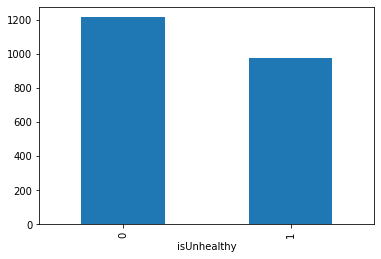

In [8]:
# GET OPENAQ DATA...
AQbyWeather.selectedScenario.printSummary()
aq_df = AQbyWeather.getOpenAqDataFrame()
    
if len(aq_df) > 0:
    # Output DataFrame properties...
    print('aq_df.shape =', aq_df.shape)
    display(aq_df)
    aq_df.groupby([AQbyWeather.mlTargetLabel]).size().plot(kind="bar")
    aq_df.to_csv(AQbyWeather.getFilenameOpenAQ(), index=False)

In [9]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
# This column removal will NOT be necessary once we can use Autogluon ignore_columns param (TBD).
AQbyWeather.selectedScenario.printSummary()
merged_df = AQbyWeather.getMergedDataFrame(noaagsod_df, aq_df)

if(len(merged_df > 0)):
    # Output DataFrame properties...
    print('merged_df.shape =', merged_df.shape)
    display(merged_df)
    merged_df.to_csv(AQbyWeather.getFilenameOther("dataMERGED"), index=False)

# TODO: Explore other ways to join the data and/or handle null values...

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
merged_df.shape = (2182, 7)


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy
0,47.3,6.8,72.0,51.1,0.02,3,0
1,44.8,3.7,82.9,44.1,0.00,3,0
2,42.8,6.9,82.9,48.0,0.00,3,0
3,43.2,2.5,73.0,45.0,0.23,3,0
4,43.5,3.8,66.9,45.0,0.00,3,0
...,...,...,...,...,...,...,...
2177,39.2,5.7,95.0,62.1,0.00,6,1
2178,44.9,6.5,95.0,66.0,0.00,6,0
2179,50.5,7.3,91.0,64.0,0.00,6,0
2180,45.1,6.4,90.0,64.0,0.00,6,0


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


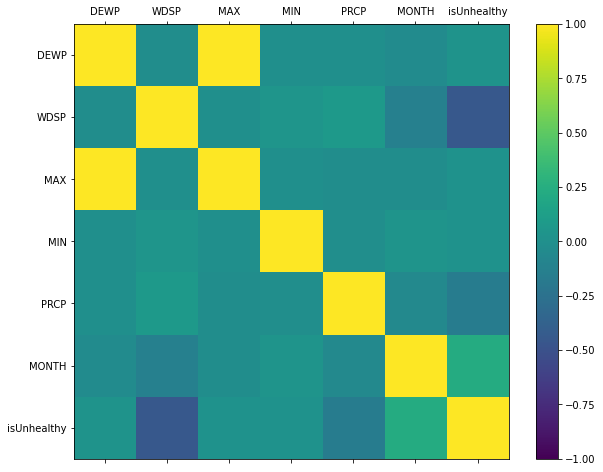

In [10]:
# Visualize correlations in our merged dataframe...
AQbyWeather.selectedScenario.printSummary()
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

In [11]:
# Additional import statements for autogluon+sklearn and split our data...
AQbyWeather.selectedScenario.printSummary()
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.33, random_state=1)
train_df.shape, validate_df.shape
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Number of training samples: 1461
Number of validation samples: 721


In [12]:
#Get test data and remove the target label column...
AQbyWeather.selectedScenario.printSummary()
test_df=validate_df.drop([AQbyWeather.mlTargetLabel],axis=1)
display(test_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,DEWP,WDSP,MAX,MIN,PRCP,MONTH
1858,48.0,5.8,100.0,72.0,0.00,7
2159,48.7,4.3,91.9,57.0,0.00,5
1715,43.7,6.0,73.0,50.0,0.00,2
201,39.3,6.1,75.9,51.1,0.00,10
1889,53.5,5.9,105.1,79.0,0.00,8
...,...,...,...,...,...,...
1511,48.4,9.2,105.1,73.9,0.00,6
1144,45.0,7.0,98.1,68.0,0.00,6
408,39.4,7.3,78.1,48.0,0.00,4
1114,45.4,5.1,69.1,48.9,0.09,5


In [13]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
AQbyWeather.selectedScenario.printSummary()
predictor = TabularPredictor(label=AQbyWeather.mlTargetLabel, 
                             eval_metric=AQbyWeather.mlEvalMetric, 
                             path=AQbyWeather.selectedScenario.getModelPath())
predictor.fit(train_data=train_df, time_limit=AQbyWeather.mlTimeLimitSecs, verbosity=2, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_bakersfield_pm25_2016-2022/"
AutoGluon Version:  0.4.2
Python Version:     3.9.13
Operating System:   Linux
Train Data Rows:    1461
Train Data Columns: 6
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14769.14 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
2022-06-10 23:25:58,711	WARNING services.py:1856 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4294963200 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.60gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
	0.833	 = Validation score   (accuracy)
	5.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.8152	 = Validation score   (accuracy)
	5.92s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ...
	0.8063	 = Validation score   (accuracy)
	0.8s	 = Training   

In [14]:
# Get dataframes for feature correlation + leaderboard AND display model evaluation...
AQbyWeather.selectedScenario.printSummary()
featureimp_df  = predictor.feature_importance(validate_df)
leaderboard_df = predictor.leaderboard(validate_df, silent=True)
display(predictor.evaluate(validate_df, auxiliary_metrics=True))

Computing feature importance via permutation shuffling for 6 features using 721 rows with 5 shuffle sets...


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


	61.86s	= Expected runtime (12.37s per shuffle set)
	14.8s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.811373092926491
Evaluations on test data:
{
    "accuracy": 0.811373092926491,
    "balanced_accuracy": 0.8103677276869141,
    "mcc": 0.6211865259807932,
    "roc_auc": 0.8859132959582388,
    "f1": 0.7982195845697329,
    "precision": 0.8029850746268656,
    "recall": 0.7935103244837758
}


{'accuracy': 0.811373092926491,
 'balanced_accuracy': 0.8103677276869141,
 'mcc': 0.6211865259807932,
 'roc_auc': 0.8859132959582388,
 'f1': 0.7982195845697329,
 'precision': 0.8029850746268656,
 'recall': 0.7935103244837758}

In [15]:
# View (and/or plot) leaderboard...
AQbyWeather.selectedScenario.printSummary()
display(leaderboard_df)
# leaderboard_df.plot(kind="bar", legend=False, figsize=(16, 4), x="model", y="score_val", xlabel="model", ylabel="score_val")

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.815534,0.832991,0.065418,0.039249,5.539229,0.065418,0.039249,5.539229,1,True,3
1,WeightedEnsemble_L2,0.815534,0.832991,0.067599,0.042083,6.579480,0.002181,0.002834,1.040251,2,True,14
2,CatBoost_BAG_L2,0.811373,0.837782,1.176221,1.106788,66.869282,0.013059,0.017067,10.017022,2,True,19
3,XGBoost_BAG_L2,0.811373,0.840520,1.218235,1.160122,62.613159,0.055073,0.070400,5.760899,2,True,23
4,WeightedEnsemble_L3,0.811373,0.840520,1.220228,1.162866,63.507878,0.001992,0.002743,0.894719,3,True,26
5,CatBoost_BAG_L1,0.809986,0.826146,0.010872,0.008100,6.767042,0.010872,0.008100,6.767042,1,True,7
6,RandomForestGini_BAG_L2,0.809986,0.817933,1.290667,1.241366,57.901429,0.127505,0.151644,1.049169,2,True,17
7,ExtraTreesGini_BAG_L1,0.808599,0.815195,0.134797,0.162754,0.720660,0.134797,0.162754,0.720660,1,True,8
8,LightGBM_BAG_L2,0.808599,0.831622,1.205601,1.120040,63.599237,0.042439,0.030318,6.746977,2,True,16
9,ExtraTreesGini_BAG_L2,0.808599,0.810404,1.289896,1.243772,57.654895,0.126733,0.154051,0.802635,2,True,20


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,importance,stddev,p_value,n,p99_high,p99_low
WDSP,0.147018,0.016787,0.000020,5,0.181584,0.112453
MONTH,0.118724,0.019057,0.000077,5,0.157964,0.079484
MAX,0.069626,0.003972,0.000001,5,0.077803,0.061448
PRCP,0.034951,0.005134,0.000054,5,0.045522,0.024381
DEWP,0.018585,0.006907,0.001921,5,0.032807,0.004364
MIN,0.016089,0.010681,0.014043,5,0.038080,-0.005903


<AxesSubplot:xlabel='feature'>

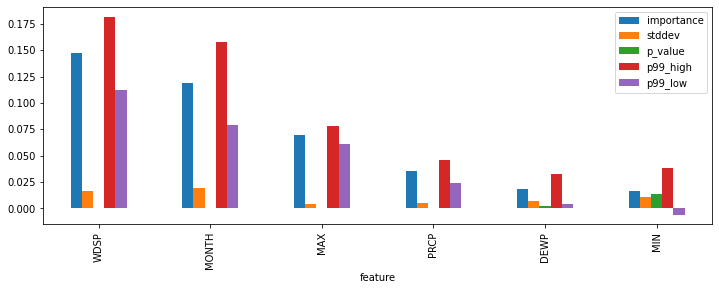

In [16]:
# View (and/or Plot) Leaderboard...
AQbyWeather.selectedScenario.printSummary()
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

In [17]:
# Make Predictions...
AQbyWeather.selectedScenario.printSummary()
y_pred = predictor.predict(test_df)
display(y_pred)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


1858    0
2159    0
1715    0
201     0
1889    1
       ..
1511    0
1144    0
408     0
1114    0
22      0
Name: isUnhealthy, Length: 721, dtype: int64

In [18]:
# Get true label values...
AQbyWeather.selectedScenario.printSummary()
y_true = validate_df[AQbyWeather.mlTargetLabel]
display(y_true)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


1858    0
2159    0
1715    0
201     0
1889    1
       ..
1511    0
1144    1
408     0
1114    0
22      0
Name: isUnhealthy, Length: 721, dtype: int64

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


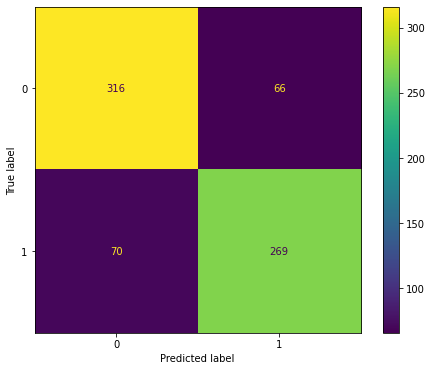

In [19]:
# View Confusion Matrix...
AQbyWeather.selectedScenario.printSummary()
cm  = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

In [20]:
# Create and save final results...
AQbyWeather.selectedScenario.printSummary()
resultsFile = AQbyWeather.getFilenameOther("dataRESULTS")
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(resultsFile, index=False)
print(f"Results saved to {resultsFile}. DONE.")
display(results_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Results saved to dataRESULTS_bakersfield_pm25_2016-2022.csv. DONE.


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy,PREDICTION
1858,48.0,5.8,100.0,72.0,0.00,7,0,0
2159,48.7,4.3,91.9,57.0,0.00,5,0,0
1715,43.7,6.0,73.0,50.0,0.00,2,0,0
201,39.3,6.1,75.9,51.1,0.00,10,0,0
1889,53.5,5.9,105.1,79.0,0.00,8,1,1
...,...,...,...,...,...,...,...,...
1511,48.4,9.2,105.1,73.9,0.00,6,0,0
1144,45.0,7.0,98.1,68.0,0.00,6,1,0
408,39.4,7.3,78.1,48.0,0.00,4,0,0
1114,45.4,5.1,69.1,48.9,0.09,5,0,0
